# Dimension Reduction VI: t-Stochastic Neighbors Embedding (t-SNE)
### Implemented in Python

<i>Patrick White</i></br>
<i>Jan 07, 2025</i>

<img src="img/dr6.png" style="height: 450px; width:auto;">

# Outline

- Theoretical Foundation
- Implementation
- PCA as a Baseline
- t-SNE
- Visualizing Perplexity
- Scikit-Learn Implementation Details
    - Parameters
    - Attributes
    - Methods

# Theoretical Foundation

t-SNE, an alternative to regular (Gaussian) SNE, is used to project data from a high-dimensional space to a lower-dimensional space, primarily for the purpose of visualizing high-dimensional data in a 2D or 3D map. Utilizing the t-distribution instead of the Gaussian reduces the tendency for points to be crowded together in the center of the map. For high-dimensional data that lies on or near a nonlinear manifold, t-SNE will tend to be more effective than linear methods.

SNE and t-SNE start by converting the high-dimensional Euclidean distances between points into conditional probabilities that represent similarities. The similarity of data point $x_j$ to $x_i$ is the conditional probability $p_{j|i}$ that point $x_i$ would pick $x_j$ as its neighbor if neighbors are picked in proportion to their probability density under a Gaussian (SNE) or t-distribution (t-SNE) centered at $x_i$. We set $p_{i|i}$ to zero, because we're only interested in pairwise similarities.

SNE and t-SNE aim to find a low-dimensional representation that minimizes KL divergence over all points, using gradient descent. 

$C = \sum_i KL(P_i || Q_i) = \sum_i \sum_j p_{j|i} ~log \frac{p_{j|i}}{q_{j|i}}$

An alternative to minimizing divergences between conditional probabilities $p_{j|i}$ and $q_{j|i}$ is to minimize a single KL divergence.

$C = KL(P||Q) = \sum_i \sum_j p_{ij} ~log \frac{p_{ij}}{q_{ij}}$

This is called symmetric because $p_{ij} = p_{ji}$ and $q_{ij} = q_{ji}$. For Gaussian SNE, the pairwise similarities in the low-dimensional space are given by:

$q_{ij} = \frac{ exp( - ||y_i-y_j||^2 ) }{ \sum_{k \neq l} exp( - ||y_k-y_l||^2 ) }$

$p_{ij} = \frac{ exp( - ||x_i-x_j||^2 / 2 \sigma^2 ) }{ \sum_{k \neq l} exp( - ||x_k-x_l||^2 / 2 \sigma^2 ) }$

If the data points are approximately uniformly distributed in the region around i in a high (e.g. $10$) dimensional manifold, and we try to model the distances from $i$ to the other data points in a two-dimensional map, we get the crowding problem. The area of the two-dimensional map that is available to accommodate moderately distant data points will not be nearly large enough compared to the area available to accommodate nearby data points.

Since symmetric SNE matches the joint probabilities of pairs of data points in the high-dimension and low-dimension space rather than their distances, we have a natural way of alleviating the crowding problem. In the high-dimensional space, we convert distances into probabilities using a Gaussian, and in the low-dimensional map, we use a distribution with heavier tails. In t-SNE, we use a t-distribution with one degree of freedom (a Cauchy distribution) in the low-dimension map.

$q_{ij} = \frac{ (1 + ||y_i-y_j||^2)^{-1} }{ \sum_{k \neq l} (1 + ||y_k-y_l||^2)^{-1} }$

Perplexity is a hyperparameter specified by the user, and can be interpreted as a smooth measure of the effective number of neighbors. Typical values are between $5$ and $50$.

$\text{Perp}(P_i) = 2^{H(P_i)}$

where $H(P_i)$ is the entropy of $P_i$ in bits.

$H(P_i) = - \sum p_{j|i} ~log_2 p_{j|i}$

# Implementation

Scikit-Learn has an implementation, the <code>sklearn.manifold.TSNE</code> class. It will require that the following dependency is up to date.

In [ ]:
# !pip install threadpoolctl==3.1.0

Image data will make for a good example, so I'll import the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits">MNIST</a> dataset from sklearn. This gives us 1797 instances of digits labeled 1 through 10. A higher-dimensional version with a greater number of samples is available, however t-SNE's main weakness is an inability to handle compute-intensive operations very quickly (we'll revisit this in the next article on UMAP).

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape

# PCA as a Baseline

As a baseline to compare to, I'll use PCA to project the data onto two dimensions.

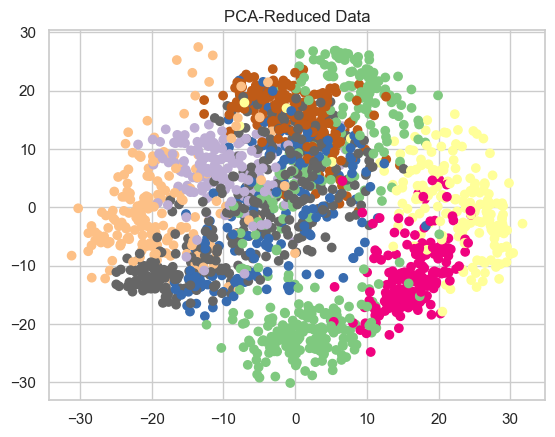

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_theme(style='whitegrid')

pca = PCA(n_components=2)
transformed = pca.fit_transform(X)

plt.scatter(transformed[:,0:1], transformed[:,1:2], c=y, cmap=sns.color_palette('Accent', as_cmap=True))
plt.title('PCA-Reduced Data');

Not terrible, there is definitely some clustering evident. But, we would like to be better able to isolate the clusters, if possible.

# t-SNE

Now, we'll see how the data looks when t-SNE is used to project is onto two dimensions.

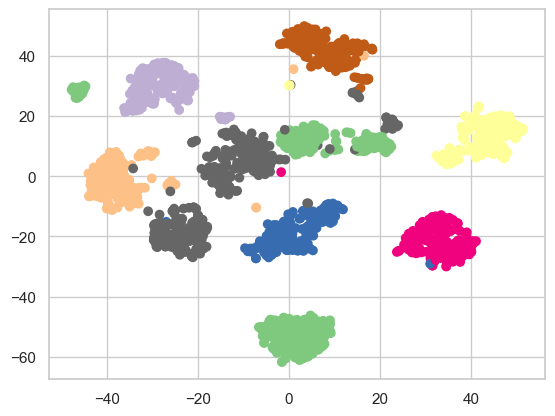

In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=123)
transformed = tsne.fit_transform(X)

plt.scatter(transformed[:,0:1],transformed[:,1:2], c=y, cmap=sns.color_palette('Accent', as_cmap=True));

We see much better class-separability. We can actually control the ratio of inter-cluster distance to intra-cluster distance using the perplexity parameter, although as it gets high enough, the data will start to fan out again (we usually pick values between 5 and 50). Above, we allowed it to use the default setting, which is 30.

# Visualizing Perplexity

The below illustrates how the sklearn MNIST data looks at varying levels of perplexity.

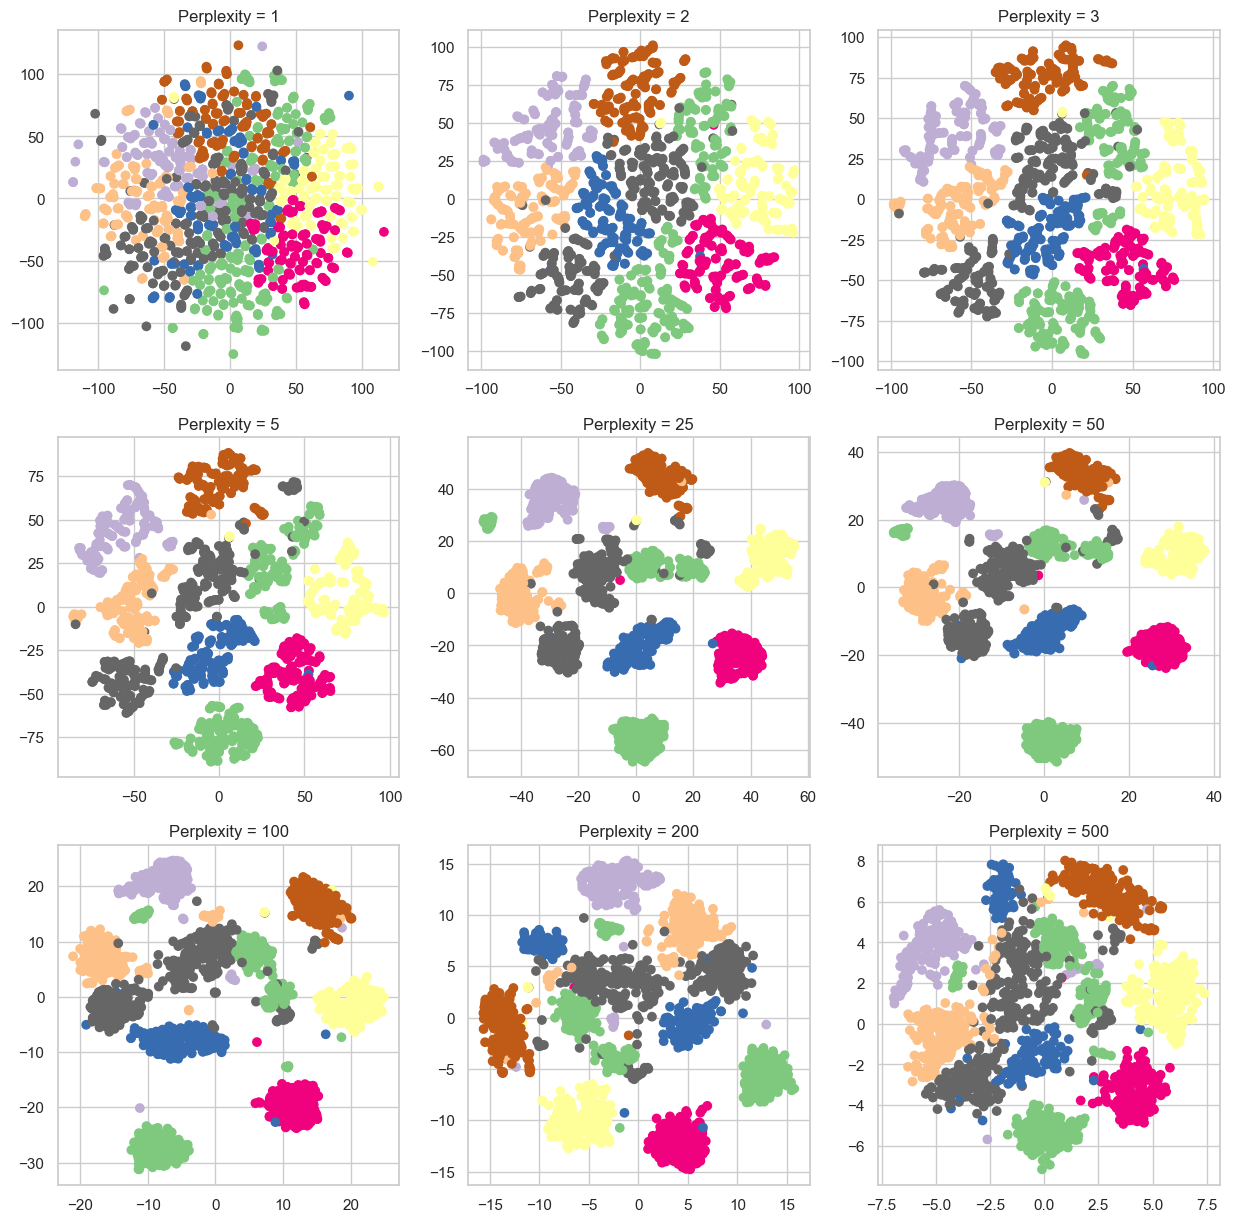

In [5]:
fig, ax = plt.subplots(3, 3, figsize = (15, 15))

perps = [ [1,2,3], [5,25,50] , [100,200,500] ]

for i in range(3):
    for j in range(3):
        tsne = TSNE(n_components=2, perplexity=perps[i][j], random_state=123)
        transformed = tsne.fit_transform(X)
        ax[i][j].scatter(transformed[:,0:1],transformed[:,1:2], c=y, cmap=sns.color_palette('Accent', as_cmap=True))
        ax[i][j].set_title(f"Perplexity = {perps[i][j]}")

# Advantages and Limitations

t-SNE can reveal clusters and patterns in data that may not be evident with other methods of dimension reduction. By preserving the local structure of data, minimizing the similarities of nearby points in a high-dimensional space, it excels at making high-dimensional data visually interpretable. In terms of limitations, it does not excel at low-rank approximation, the way a method like SVD might. The results are sensitive to the choice of parameters and multiple runs can yield different results due to its stochastic nature. Perhaps most importantly, it is a computationally expensive method that can be very slow for large datasets. 

The next article in the series, on UMAP, offers an alternative with very similar functionality, but a much faster solving algorithm.

# Scikit-Learn Implementation Details

## Parameters

- <code>n_components</code> (default=2): dimension of the embedded space.

- <code>perplexity</code> (default=30.0): related to the number of nearest neighbors used in other manifold learning algorithms. Larger datasets usually require higher perplexity. It must be lower than the number of samples.

- <code>early_exaggeration</code> (default=12.0): controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space.

- <code>learning_rate</code> (default='auto'): step-size to take during iterations of training. If too high, the data may look like a ball, with points equidistant. If too low, most points may look compressed in a dense cloud.

- <code>max_iter</code> (default=300): max number of training iterations.

- <code>metric</code> (default='euclidean'): the metric to use in calculating pairwise differences. This can be a metric listed in pairwise.PAIRWISE_DISTANCE_FUNCTIONS or another callable function.

- <code>random_state</code> (default=None): random seed for reproducibility.


## Attributes

- <code>embedding_</code>: stores the embedding vectors.

- <code>kl_divergence</code>: KL divergence after optimization.

- <code>n_features_in</code>: number of features seen during fit.


## Methods

- <code>fit</code>: fit an instance of the model to the data.

- <code>fit_transform</code>: fit an instance of the model to the data, and apply the dimensionality reduction to the data.

# References

- Van der Maaten, L. (2008). Visualizing Data using t-SNE. Journal of Machine Learning Research. https://doi.org/2579-2605

- Scikit-Learn (n.d.). Manifold Learning. Scikit-Learn User Guide. https://scikit-learn.org/stable/modules/manifold.html#t-sne

- https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne